In [1]:
#set adequate environment
import os
import sys
import theano
import keras
theano.config.gcc.cxxflags = '-march=corei7'

Using Theano backend.


In [2]:
#load needed things
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.layers import Input, Activation, Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import interp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import itertools
import math
import ROOT
import cPickle as pickle
from UserFunctions import *

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
#load events
comparison = '>='
njets = 2
min4lmass = 118
max4lmass = 130

filein = open('hzz4l_{0}jets_m4l{1}-{2}GeV_shuffledFS.pkl'.format(njets,min4lmass,max4lmass),'r')
events = pickle.load( filein )
filein.close()

In [4]:
del events['myqqZZ']
del events['ggH']

#shows events and statistics
class_weight = {}
keys = []
for ik in events:
    nevents = 0
    sumw = 0
    nevents = len(events[ik])
    for i in range(len(events[ik])):
        sumw += events[ik][i][2]

    print '%s events: %i, normalized: %.4f' % (ik,nevents,sumw)
    class_weight[ik] = sumw
    keys.append(ik) 
    
#only MC
summ = 0
for ik in events:
    if(ik != 'Data'):
        summ += len(events[ik])
print 'MC total events: %i' % summ
class_weight['myqqZZ'] = class_weight['qqZZ']
vhcw = class_weight['WH']+class_weight['ZH']
class_weight['WH'] = vhcw
class_weight['ZH'] = vhcw

ttZ events: 183, normalized: 0.2655
ZH events: 10135, normalized: 0.4547
VBF events: 38623, normalized: 3.1096
qqZZ events: 214, normalized: 1.5321
WH events: 21967, normalized: 0.6385
ttH events: 17486, normalized: 0.4770
ggZZ events: 865, normalized: 0.1468
Data events: 16, normalized: 16.0000
HJJ events: 7444, normalized: 6.7996
MC total events: 96917


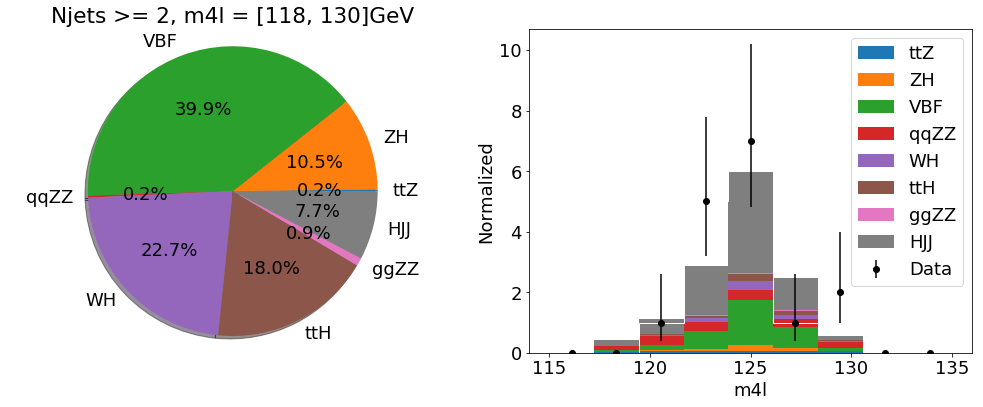

In [5]:
fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(14)
pyp.rc("font", size=18)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1 = fig.add_subplot(121)
composition = []
components = []
for ik in events:
    if(ik == 'myqqZZ'):
        continue
    if(ik != 'Data'):
        composition.append( len(events[ik]) )
        components.append(ik)
pyp.pie(composition, labels=components, autopct='%1.1f%%', shadow=True, startangle=0)
pyp.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
pyp.title('Njets {0} {1}, m4l = [{2}, {3}]GeV'.format(comparison,njets,min4lmass,max4lmass))

fig2 = fig.add_subplot(122)
masses4l = []
weights = []
dmasses4l = []
for ik in events:
    if(ik == 'myqqZZ'):
        continue
    if(ik != 'Data'):
        w = []
        m = []
        for iev in range(len(events[ik])):
                w.append(events[ik][iev][2])
                m.append(events[ik][iev][3])
        weights.append(w)
        masses4l.append(m)
    else:
        for iev in range(len(events[ik])):
                dmasses4l.append(events[ik][iev][3])
                

bins = np.linspace(115,135,10)
pyp.hist(masses4l, bins, weights=weights, histtype='bar', stacked=True, label=components)

n, bins, _ = pyp.hist(dmasses4l, bins, histtype='step', color='white')
mid = 0.5*(bins[1:] + bins[:-1])
eyh = []
eyl = []
for i in range(len(n)):
    if(n[i] != 0):
        eyl.append( -0.5+math.sqrt(n[i]+0.25) )
        eyh.append( 0.5+math.sqrt(n[i]+0.25) )
    else:
        eyl.append(0)
        eyh.append(0)
    #print 'eyl: %.2f, eyh: %.2f' % (eyl[i],eyh[i])
m4l_err = [eyl,eyh]
pyp.errorbar(mid, n, yerr=m4l_err, fmt='o', color='black', label='Data')

pyp.xlabel('m4l')
pyp.ylabel('Normalized')
#pyp.ylim([0.001,10])
pyp.legend(loc='upper right')
#pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

In [6]:
#creates a copy from orig events
orig_events = events
events = {}
events['VBF'] = orig_events['VBF']
events['HJJ'] = orig_events['HJJ']
events['ttH'] = orig_events['ttH']
events['ZH'] = orig_events['ZH']
events['WH'] = orig_events['WH']
events['qqZZ'] = orig_events['qqZZ']
events['ggZZ'] = orig_events['ggZZ']
events['ttZ'] = orig_events['ttZ']
#events['myqqZZ'] = orig_events['myqqZZ']

In [7]:
#organize events and splits mc into train, validation and test; data it's kept full
#the split_factor sets train size then validation and test sets have the same size
split_factor = 0.8
full_event_train, full_event_test, full_event_data = splitInputs(events, split_factor, class_weight)

Train set size: 77531
Test set size: 19386
Data set size: 0


In [8]:
#to select how many jets to use;  eg. 7 = 4leptons + 3jets
nparticles = 7
features = {
    'pt' : None,
    'eta': None,
    'phi': None
    #'e'  : None
}
nfeatures = len(features)

In [9]:
#just to organize index of important quantities
djet_index   = 1
mela_index   = 2
weight_index = 3
class_weight_index = 4

#prepare train set
X = {}
Y = {}
X['train'], Y['train'], Ydjet_train, Ymela_train, weights_train_set, scales_train_set = prepareSet(full_event_train, nparticles, nfeatures, djet_index, mela_index, weight_index, class_weight_index)

siev: 30898
biev: 46633


In [10]:
#prepare test set
X['test'], Y['test'], Ydjet_test, Ymela_test, weights_test_set, scales_test_set = prepareSet(full_event_test, nparticles, nfeatures, djet_index, mela_index, weight_index, class_weight_index)

siev: 7725
biev: 11661


In [11]:
#parameters for training
nepochs = 800
wait_for = 30
sbatch = 128
opt = Adam()
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=wait_for)

In [12]:
#DNN network
print "---------- DNN Topology --------- "
dnn_model = Sequential()
dnn_model.add(Dense(7, input_shape=(nparticles*nfeatures,), activation='relu', kernel_initializer='random_uniform'))
dnn_model.add(Dense(5, activation='relu', kernel_initializer='random_uniform'))    
dnn_model.add(Dense(3, activation='relu', kernel_initializer='random_uniform'))    
dnn_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))    
dnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print dnn_model.summary()

---------- DNN Topology --------- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 154       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# updatable plot
from IPython.display import clear_output
class Tscheduler(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.logs = []
        self.trocs = []
        self.vrocs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        Y_score = dnn_model.predict(X['train'])
        fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.trocs.append(roc_auc)
        Y_score = dnn_model.predict(X['test'])
        fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.vrocs.append(roc_auc)
        self.i += 1
        
        clear_output(wait=True)
        fig = pyp.figure()
        fig.set_figheight(6)
        fig.set_figwidth(13)
        
        fig1 = fig.add_subplot(121)
        pyp.plot(self.x, self.losses, label="tloss: %f" % self.losses[len(self.losses)-1]) 
        pyp.plot(self.x, self.val_losses, label="vloss: %f" % self.val_losses[len(self.val_losses)-1])
        #pyp.plot(self.x, self.accs, label="tacc: %f" % self.accs[len(self.accs)-1]) 
        #pyp.plot(self.x, self.val_accs, label="vacc: %f" % self.val_accs[len(self.val_accs)-1])
        #c_lrate = K.eval(self.model.optimizer.lr)
        #pyp.title("Current LR: %f" % c_lrate)
        #c_momentum = K.eval(self.model.optimizer.momentum)
        #pyp.title("Current M: %f" % c_momentum)
        pyp.xlabel('epochs')
        pyp.ylabel('Loss')
        pyp.legend()
        #pyp.ylim([0.7,1.2])
        pyp.grid(True)
        #pyp.show()
        
        fig2 = fig.add_subplot(122)
        pyp.plot(self.x, self.trocs, color='blue', label='Current train AUC = %0.3f' % self.trocs[len(self.trocs)-1])
        pyp.plot(self.x, self.vrocs, color='red', label='Current   test AUC = %0.3f' % self.vrocs[len(self.vrocs)-1])
        #pyp.ylim([0, 1.0])
        pyp.xlabel('epochs')
        pyp.ylabel('AUC')
        pyp.title('ROC evolution')
        pyp.legend()
        pyp.grid(True)
        #pyp.show()

        pyp.tight_layout()
        fig = pyp.show()

        #changing lr based on loss
        #if(len(self.losses) > 20):
        #    lsum1 = 0
        #    lsum2 = 0
        #    for i in range(6):
        #        if(i < 3):
        #            lsum1 += self.losses[len(self.losses)-1-i]/3.
        #        else:
        #            lsum2 += self.losses[len(self.losses)-1-i]/3.
        #    if(math.fabs(lsum2-lsum1) < 0.01):
        #        n_lrate = c_lrate*(1 - 1/20.)
        #        K.set_value(self.model.optimizer.lr, n_lrate)
        #else:
        #    n_lrate = self.losses[len(self.losses)-1]*0.001
        #    K.set_value(self.model.optimizer.lr, n_lrate)
        
        #initial_lrate = 0.001
        #drop = 0.6
        #epochs_drop = 100
        #lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        #K.set_value(self.model.optimizer.lr, 0.001)
        
        #stop training if training and testing Loss get too away
        #if(epoch > 50):
        #    train_sum = 0
        #    val_sum = 0
        #    for i in range(30):
        #        train_sum += self.losses[len(self.losses)-1-i]/6.
        #        val_sum += self.val_losses[len(self.val_losses)-1-i]/6.
        #    if(train_sum-val_sum < -0.02):
        #        self.model.stop_training = True
        #        print "Stoping training!"
                
            
Tschedule = Tscheduler()

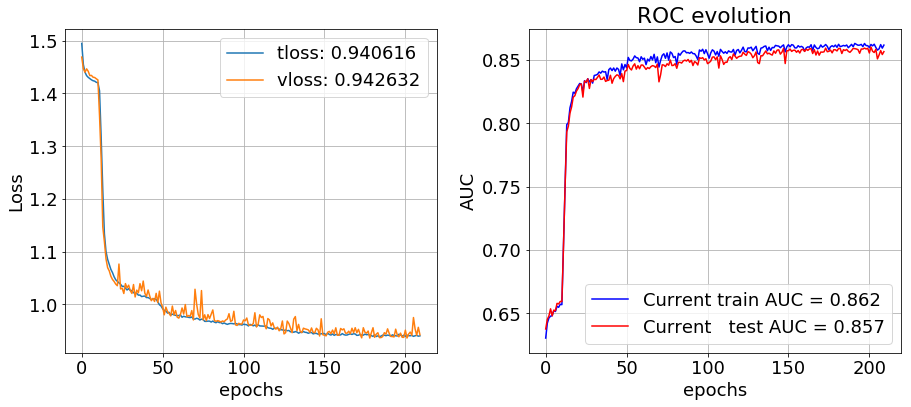

In [14]:
filepath1="weights_dnn.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

#train the DNN
history1 = dnn_model.fit(X['train'],
                        Y['train'], 
                        sample_weight=scales_train_set,
                        #sample_weight=weights_train_set,
                        validation_data=(X['test'],
                                         Y['test']
                                         ,scales_test_set
                                         #,weights_test_set
                                        ), 
                        epochs=nepochs,
                        batch_size=sbatch, 
                        verbose=0,
                        callbacks=[checkpoint1,early_stopping,Tschedule]
                       )

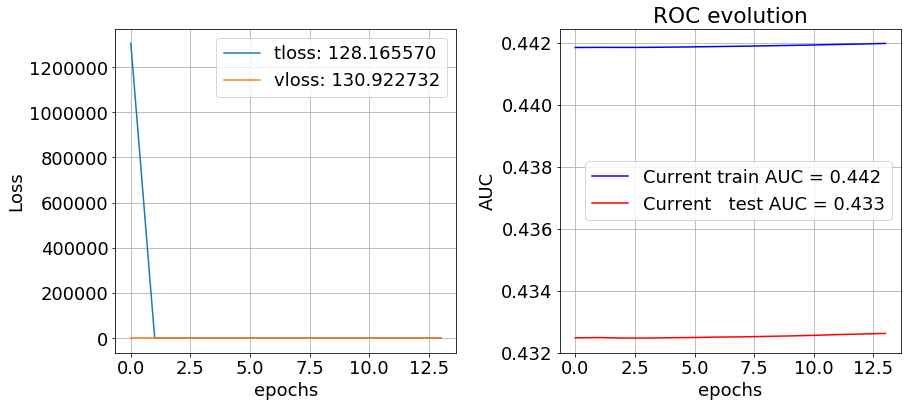

In [ ]:
dnn_model.compile(loss='mape', optimizer=opt, metrics=['accuracy'])
dnn_model.load_weights(filepath1)

#train the DNN
history1 = dnn_model.fit(X['train'],
                        Y['train'], 
                        sample_weight=scales_train_set,
                        #sample_weight=weights_train_set,
                        validation_data=(X['test'],
                                         Y['test']
                                         ,scales_test_set
                                         #,weights_test_set
                                        ), 
                        epochs=nepochs,
                        batch_size=sbatch, 
                        verbose=0,
                        callbacks=[checkpoint1,early_stopping,Tschedule]
                       )

In [ ]:
#shallow network
print "---------- Shallow NN(15) Topology --------- "
nn15_model = Sequential()
nn15_model.add(Dense(15, input_shape=(nparticles*nfeatures,), activation='relu', kernel_initializer='random_uniform'))
nn15_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))    
nn15_model.compile(loss='mape', optimizer=opt, metrics=['accuracy'])
print nn15_model.summary()

In [ ]:
# updatable plot
from IPython.display import clear_output
class Tscheduler2(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.logs = []
        self.trocs = []
        self.vrocs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        Y_score = nn15_model.predict(X['train'])
        fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.trocs.append(roc_auc)
        Y_score = nn15_model.predict(X['test'])
        fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.vrocs.append(roc_auc)
        self.i += 1
        
        clear_output(wait=True)
        fig = pyp.figure()
        fig.set_figheight(6)
        fig.set_figwidth(13)
        
        fig1 = fig.add_subplot(121)
        pyp.plot(self.x, self.losses, label="tloss: %f" % self.losses[len(self.losses)-1]) 
        pyp.plot(self.x, self.val_losses, label="vloss: %f" % self.val_losses[len(self.val_losses)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('Loss')
        pyp.legend()
        pyp.grid(True)
        
        fig2 = fig.add_subplot(122)
        pyp.plot(self.x, self.trocs, color='blue', label='Current train AUC = %0.3f' % self.trocs[len(self.trocs)-1])
        pyp.plot(self.x, self.vrocs, color='red', label='Current   test AUC = %0.3f' % self.vrocs[len(self.vrocs)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('AUC')
        pyp.title('ROC evolution')
        pyp.legend()
        pyp.grid(True)

        pyp.tight_layout()
        fig = pyp.show()                
            
Tschedule2 = Tscheduler2()

In [ ]:
filepath2="weights_nn15.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

#train the NN15
history2 = nn15_model.fit(X['train'],
                        Y['train'], 
                        sample_weight=scales_train_set,
                        #sample_weight=weights_train_set,
                        validation_data=(X['test'],
                                         Y['test']
                                         ,scales_test_set
                                         #,weights_test_set
                                        ), 
                        epochs=nepochs,
                        batch_size=sbatch, 
                        verbose=0,
                        callbacks=[checkpoint2,early_stopping,Tschedule2]
                       )

In [ ]:
print "---------- Shallow NN(30) Topology --------- "
nn30_model = Sequential()
nn30_model.add(Dense(30, input_shape=(nparticles*nfeatures,), activation='relu', kernel_initializer='random_uniform'))
nn30_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))    
nn30_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print nn30_model.summary()

In [ ]:
# updatable plot
from IPython.display import clear_output
class Tscheduler3(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.logs = []
        self.trocs = []
        self.vrocs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        Y_score = nn30_model.predict(X['train'])
        fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.trocs.append(roc_auc)
        Y_score = nn30_model.predict(X['test'])
        fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
        roc_auc = auc(fpr, tpr, reorder=True)
        self.vrocs.append(roc_auc)
        self.i += 1
        
        clear_output(wait=True)
        fig = pyp.figure()
        fig.set_figheight(6)
        fig.set_figwidth(13)
        
        fig1 = fig.add_subplot(121)
        pyp.plot(self.x, self.losses, label="tloss: %f" % self.losses[len(self.losses)-1]) 
        pyp.plot(self.x, self.val_losses, label="vloss: %f" % self.val_losses[len(self.val_losses)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('Loss')
        pyp.legend()
        pyp.grid(True)
        
        fig2 = fig.add_subplot(122)
        pyp.plot(self.x, self.trocs, color='blue', label='Current train AUC = %0.3f' % self.trocs[len(self.trocs)-1])
        pyp.plot(self.x, self.vrocs, color='red', label='Current   test AUC = %0.3f' % self.vrocs[len(self.vrocs)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('AUC')
        pyp.title('ROC evolution')
        pyp.legend()
        pyp.grid(True)

        pyp.tight_layout()
        fig = pyp.show()                
            
Tschedule3 = Tscheduler3()

In [ ]:
filepath3="weights_nn30.hdf5"
checkpoint3 = ModelCheckpoint(filepath3, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

#train the NN30
history3 = nn30_model.fit(X['train'],
                        Y['train'], 
                        sample_weight=scales_train_set,
                        #sample_weight=weights_train_set,
                        validation_data=(X['test'],
                                         Y['test']
                                         ,scales_test_set
                                         #,weights_test_set
                                        ), 
                        epochs=nepochs,
                        batch_size=sbatch, 
                        verbose=0,
                        callbacks=[checkpoint3,early_stopping,Tschedule3]
                       )

In [ ]:
# load final best weights
dnn_model.load_weights(filepath1)
nn15_model.load_weights(filepath2)
nn30_model.load_weights(filepath3)

In [ ]:
fig = pyp.figure(figsize=(10,10))

#train set normalized roc
Y_score = dnn_model.predict(X['train'])
fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', color='blue', label='DNN train AUC = %0.2f' % roc_auc)

#test set unormalized roc
Y_score = dnn_model.predict(X['test'])
fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, color='blue', label='DNN test AUC = %0.2f' % roc_auc)

#train set normalized roc
Y_score = nn15_model.predict(X['train'])
fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', color='red', label='NN(15) train AUC = %0.2f' % roc_auc)

#test set unormalized roc
Y_score = nn15_model.predict(X['test'])
fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, color='red', label='NN(15) test AUC = %0.2f' % roc_auc)

#train set normalized roc
Y_score = nn30_model.predict(X['train'])
fpr, tpr, thresholds = roc_curve(Y['train'], Y_score, sample_weight=weights_train_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', color='green', label='NN30 train AUC = %0.2f' % roc_auc)

#test set unormalized roc
Y_score = nn30_model.predict(X['test'])
fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, color='green', label='NN30 test AUC = %0.2f' % roc_auc)

#random
pyp.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck')

pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver Operating Characteristic')
pyp.legend(loc="lower right")
pyp.grid(True)
pyp.show()

In [ ]:
fig = pyp.figure(figsize=(10,10))

val_loss = np.asarray(history.history['val_loss'])
loss = np.asarray(history.history['loss'])
pyp.plot(loss, label='loss train')
pyp.plot(val_loss, label='loss validation')
acc = np.asarray(history.history['acc'])
val_acc = np.asarray(history.history['val_acc'])
pyp.plot(val_acc, label='acc validation')
pyp.plot(acc, label='acc train')

pyp.legend()
pyp.xlabel('epoch')
#pyp.ylim([0.1,1])
#pyp.gca().set_yscale("log")
pyp.show()

In [ ]:
fig = pyp.figure(figsize=(10,10))

#normalized rocs
fpr, tpr, thresholds = roc_curve(Y['test'], Ydjet_test, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', lw=2, color='blue', label=('Djet test AUC = %0.2f' % roc_auc))

fpr, tpr, thresholds = roc_curve(Y['test'], Ymela_test, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', lw=2, color='red', label=('MELA test AUC = %0.2f' % roc_auc))

Y_score = dnn_model.predict(X['test'])
fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr,reorder=True)
pyp.plot(fpr, tpr, linestyle='--', lw=2, color='violet', label=('DNN test AUC = %0.2f' % roc_auc))


pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver Operating Characteristic')
pyp.legend(loc="lower right")
pyp.grid(True)
pyp.show()

In [ ]:
#plot S/B ratio vs S eff (only test set)
signal_sumw = 0
for iev in range(len(full_event_test)):
    if(full_event_test[iev][0] == 'VBF'):
        signal_sumw += full_event_test[iev][weight_index]

djet_sb = []
djet_seff = []
mela_sb = []
mela_seff = []
dnn_sb = []
dnn_seff = []
djet_cuts = []
mela_cuts = []
dnn_cuts = []

efull_sdjet = []
efull_bdjet = []
efull_smela = []
efull_bmela = []
efull_sdnn = []
efull_bdnn = []
esweights = []
ebweights = []

for cut in range(200):
    icut = cut/100.
    
    s_djet = 0
    s_mela = 0
    s_dnn = 0
    b_djet = 0
    b_mela = 0
    b_dnn = 0
    for i in range(len(Y['test'])):
        djet = Ydjet_test[i]
        mela = Ymela_test[i]
        dnn = Y_score[i][0]
        weight = weights_test_set[i]
        
        if(Y['test'][i] == 1):
            if(cut == 0):
                efull_sdjet.append( djet )
                efull_smela.append( mela )
                efull_sdnn.append( dnn )
                esweights.append( weight )
            
            if(djet > icut):
                s_djet += weight
            if(mela > icut):
                s_mela += weight
            if(dnn > icut):
                s_dnn += weight
        else:
            if(cut == 0):
                efull_bdjet.append( djet )
                efull_bmela.append( mela )
                efull_bdnn.append( dnn )
                ebweights.append( weight )
            
            if(djet > icut):
                b_djet += weight
            if(mela > icut):
                b_mela += weight
            if(dnn > icut):
                b_dnn += weight
    
    if(b_djet > 0):
        djet_sb.append(s_djet/b_djet)
        djet_seff.append(s_djet/signal_sumw)
        djet_cuts.append(icut)
    
    if(b_mela > 0):
        mela_sb.append(s_mela/b_mela)
        mela_seff.append(s_mela/signal_sumw)
        mela_cuts.append(icut)
    
    if(b_dnn > 0):
        #print 'cut: %.3f, s_dnn: %.3f, b_dnn: %.3f, sb: %.3f' % (icut, s_dnn,b_dnn,s_dnn/b_dnn)
        dnn_sb.append(s_dnn/b_dnn)
        dnn_seff.append(s_dnn/signal_sumw)
        dnn_cuts.append(icut)
    
    #if(b_djet > 0 and b_mela > 0 and b_dnn > 0):
        #print 'cut: %.2f, dnn_e: %.2f, dnn_sb: %.2f, mela_e: %.2f, mela_sb: %.2f, djet_e: %.2f, djet_sb: %.2f' % (icut,s_dnn/signal_sumw,s_dnn/b_dnn,s_mela/signal_sumw,s_mela/b_mela,s_djet/signal_sumw,s_djet/b_djet)

In [ ]:
tfull_sdjet = []
tfull_bdjet = []
tfull_smela = []
tfull_bmela = []
tfull_sdnn = []
tfull_bdnn = []
tsweights = []
tbweights = []

for iev in range(len(Y_score)):
    djet = Ydjet_train[iev]
    mela = Ymela_train[iev]
    dnn = Y_score[iev][0]
    weight = weights_train_set[iev]

    if(Y['train'][iev] == 1):
        tfull_sdjet.append( djet )
        tfull_smela.append( mela )
        tfull_sdnn.append( dnn )
        tsweights.append( weight )
    else:
        tfull_bdjet.append( djet )
        tfull_bmela.append( mela )
        tfull_bdnn.append( dnn )
        tbweights.append( weight )

In [ ]:
fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(131)
pyp.plot(djet_seff, djet_sb, lw=2, color='blue', label='Djet')
pyp.plot(mela_seff, mela_sb, lw=2, color='red', label='MELA')
pyp.plot(dnn_seff, dnn_sb, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
pyp.xlabel('Signal eff')
pyp.ylim([0, 10])
pyp.ylabel('S/B')
pyp.legend(loc="upper right")
pyp.grid(True)

fig1 = fig.add_subplot(132)
pyp.plot(djet_cuts, djet_sb, lw=2, color='blue', label='Djet')
pyp.plot(mela_cuts, mela_sb, lw=2, color='red', label='MELA')
pyp.plot(dnn_cuts, dnn_sb, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
pyp.ylim([0, 10])
pyp.xlabel('Cut')
pyp.ylabel('S/B')
pyp.legend(loc="upper left")
pyp.grid(True)

fig1 = fig.add_subplot(133)
pyp.plot(djet_cuts, djet_seff, lw=2, color='blue', label='Djet')
pyp.plot(mela_cuts, mela_seff, lw=2, color='red', label='MELA')
pyp.plot(dnn_cuts, dnn_seff, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
pyp.ylim([0, 1])
pyp.xlabel('Cut')
pyp.ylabel('Signal eff')
pyp.legend(loc="upper right")
pyp.grid(True)

pyp.tight_layout()
fig = pyp.show()

In [ ]:
fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(131)
bins = np.linspace(0, 3, 50)
pyp.hist(tfull_sdjet, bins, weights=tsweights, alpha=0.5, color='red', label='s-train')
pyp.hist(tfull_bdjet, bins, weights=tbweights, alpha=0.5, color='blue',label='b-train')
pyp.hist(efull_sdjet, bins, weights=esweights, linestyle='--', histtype='step', alpha=0.5, color='red', label='s-test')
pyp.hist(efull_bdjet, bins, weights=ebweights, linestyle='--', histtype='step', alpha=0.5, color='blue',label='b-test')
pyp.xlabel('Djet')
pyp.ylabel('Normalized')
pyp.ylim([0.002,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

fig2 = fig.add_subplot(132)
bins = np.linspace(-0.05, 1.05, 50)
pyp.hist(tfull_smela, bins, weights=tsweights, alpha=0.5, color='red', label='s-train')
pyp.hist(tfull_bmela, bins, weights=tbweights, alpha=0.5, color='blue',label='b-train')
pyp.hist(efull_smela, bins, weights=esweights, linestyle='--', histtype='step', alpha=0.5, color='red', label='s-test')
pyp.hist(efull_bmela, bins, weights=ebweights, linestyle='--', histtype='step', alpha=0.5, color='blue',label='b-test')
pyp.xlabel('MELA')
pyp.ylim([0.002,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

fig3 = fig.add_subplot(133)
bins = np.linspace(-0.05, 1.05, 50)
pyp.hist(tfull_sdnn, bins, weights=tsweights, alpha=0.5, color='red', label='s-train')
pyp.hist(tfull_bdnn, bins, weights=tbweights, alpha=0.5, color='blue',label='b-train')
pyp.hist(efull_sdnn, bins, weights=esweights, linestyle='--', histtype='step', alpha=0.5, color='red', label='s-test')
pyp.hist(efull_bdnn, bins, weights=ebweights, linestyle='--', histtype='step', alpha=0.5, color='blue',label='b-test')
pyp.xlabel('DNN')
pyp.ylim([0.002,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

In [ ]:
#split datasets
full_event_train, full_event_test, full_event_data = splitInputs(orig_events, split_factor, class_weight)
#normalized ROCs
print '******** ROCs from DNN *********'
fig = pyp.figure(figsize=(10,10))
colors = ['black','blue','violet','green','orange','cyan','pink','yellow','red','gray','brown']

Y_truth = {}
X = {}
Weights = {}
for ik in keys:
    Y_truth[ik] = []
    X[ik] = []
    Weights[ik] = []

for iev in range(len(full_event_test)):
    if(full_event_test[iev][0] == 'Data'):
        continue
    
    if(full_event_test[iev][0] == 'VBF'):
        Y_truth['VBF'].append(1)
        x = []
        Weights['VBF'].append(full_event_test[iev][weight_index])
        for ip in range(nparticles):
            for j in range(nfeatures):
                prop = full_event_test[iev][ip+8][j]
                if(prop != -999):
                    x.append(prop)
                else:
                    x.append(0)
        X['VBF'].append(x)
        
    else:
        Y_truth[full_event_test[iev][0]].append(0)
        x = []
        Weights[full_event_test[iev][0]].append(full_event_test[iev][weight_index])
        for ip in range(nparticles):
            for j in range(nfeatures):
                prop = full_event_test[iev][ip+8][j]
                if(prop != -999):
                    x.append(prop)
                else:
                    x.append(0)
        X[full_event_test[iev][0]].append(x)
        
ic = 0
for ik in Y_truth:
    if(ik == 'VBF' or ik == 'Data' or ik == 'myqqZZ'):
        continue
    cX = np.concatenate([X['VBF'],X[ik]])
    cY = np.concatenate([Y_truth['VBF'],Y_truth[ik]])
    cW = np.concatenate([Weights['VBF'],Weights[ik]])
    Y_score = dnn_model.predict(cX)
    fpr, tpr, thresholds = roc_curve(cY, Y_score, sample_weight=cW)
    roc_auc = auc(fpr, tpr,reorder=True)
    print 'VBF vs ',ik,' -- ROC AUC: %.2f' % roc_auc
    pyp.plot(fpr, tpr, lw=2, color=colors[ic], label=('VBF vs %s (area = %0.2f)' % (ik,roc_auc)))
    ic += 1
    
#pyp.xlim([0, 1.0])
#pyp.ylim([0, 1.0])
#pyp.xlabel('False Positive Rate')
#pyp.ylabel('True Positive Rate')
#pyp.title('Receiver Operating Characteristic')
#pyp.legend(loc="lower right")
#pyp.grid(True)
#pyp.show()

In [ ]:
#normalized ROCs
print '******** ROCs from MELA *********'
#fig = pyp.figure(figsize=(10,10))
colors = ['black','blue','violet','green','orange','cyan','pink','yellow','red','gray','brown']

Y_truth = {}
X = {}
Weights = {}
for ik in keys:
    Y_truth[ik] = []
    X[ik] = []
    Weights[ik] = []

for iev in range(len(full_event_test)):
    if(full_event_test[iev][0] == 'Data'):
        continue
    
    if(full_event_test[iev][0] == 'VBF'):
        Y_truth['VBF'].append(1)
        Weights['VBF'].append(full_event_test[iev][weight_index])
        X['VBF'].append(full_event_test[iev][mela_index])
        
    else:
        Y_truth[full_event_test[iev][0]].append(0)
        Weights[full_event_test[iev][0]].append(full_event_test[iev][weight_index])
        X[full_event_test[iev][0]].append(full_event_test[iev][mela_index])
        
ic = 0
for ik in Y_truth:
    if(ik == 'VBF' or ik == 'Data' or ik == 'myqqZZ'):
        continue
    Y_score = np.concatenate([X['VBF'],X[ik]])
    cY = np.concatenate([Y_truth['VBF'],Y_truth[ik]])
    cW = np.concatenate([Weights['VBF'],Weights[ik]])
    fpr, tpr, thresholds = roc_curve(cY, Y_score, sample_weight=cW)
    roc_auc = auc(fpr, tpr,reorder=True)
    print 'VBF vs ',ik,' -- ROC AUC: %.2f' % roc_auc
    pyp.plot(fpr, tpr, linestyle='--', lw=2, color=colors[ic], label=('VBF vs %s (area = %0.2f)' % (ik,roc_auc)))
    ic += 1
    
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver Operating Characteristic')
pyp.legend(loc="lower right")
pyp.grid(True)
pyp.show()

In [ ]:
#plot S/B ratio vs S eff ** ALL EVENTS DO GET STATISTIC COMPARABLE TO DATA **
#del orig_events['myqqZZ']
full_event_train, full_event_test, full_event_data = splitInputs(orig_events, 0.0, class_weight)

#create scores and labels
X = {}
Y = {}
Xdata = {}
Ydata = {}
X['test'], Y['test'], Ydjet_test, Ymela_test, weights_test_set, scales_test_set = prepareSet(full_event_test, nparticles, nfeatures, djet_index, mela_index, weight_index, class_weight_index)
Xdata['test'], Ydata['test'], Ydjet_data, Ymela_data, weights_data, scales_data = prepareSet(full_event_data, nparticles, nfeatures, djet_index, mela_index, weight_index, class_weight_index)

#make predictions
PMC = dnn_model.predict(X['test'])
PData = dnn_model.predict(Xdata['test'])

signal_sumw = 0
for iev in range(len(full_event_test)):
    if(full_event_test[iev][0] == 'VBF'):
        signal_sumw += full_event_test[iev][weight_index]

djet_sb = []
djet_seff = []
mela_sb = []
mela_seff = []
dnn_sb = []
dnn_seff = []
djet_cuts = []
mela_cuts = []
dnn_cuts = []

full_sdjet = []
full_bdjet = []
full_ddjet = []
full_smela = []
full_bmela = []
full_dmela = []
full_sdnn = []
full_bdnn = []
full_ddnn = []
sweights = []
bweights = []
dweights = []

for cut in range(200):
    icut = cut/100.
    
    s_djet = 0
    s_mela = 0
    s_dnn = 0
    b_djet = 0
    b_mela = 0
    b_dnn = 0
    for i in range(len(Y['test'])):
        djet = Ydjet_test[i]
        mela = Ymela_test[i]
        dnn = PMC[i][0]
        weight = weights_test_set[i]


        if(cut == 0 and i < len(PData)):
            ddjet = Ydjet_data[i]
            dmela = Ymela_data[i]
            ddnn = PData[i][0]
            dweight = weights_data[i]
            full_ddjet.append( ddjet )
            full_dmela.append( dmela )
            full_ddnn.append( ddnn )
            dweights.append( dweight )
            
        if(Y['test'][i] == 1):
            if(cut == 0):
                full_sdjet.append( djet )
                full_smela.append( mela )
                full_sdnn.append( dnn )
                sweights.append( weight )
            
            if(djet > icut):
                s_djet += weight
            if(mela > icut):
                s_mela += weight
            if(dnn > icut):
                s_dnn += weight
        else:
            if(cut == 0):
                full_bdjet.append( djet )
                full_bmela.append( mela )
                full_bdnn.append( dnn )
                bweights.append( weight )
            
            if(djet > icut):
                b_djet += weight
            if(mela > icut):
                b_mela += weight
            if(dnn > icut):
                b_dnn += weight
    
    if(b_djet > 0):
        djet_sb.append(s_djet/b_djet)
        djet_seff.append(s_djet/signal_sumw)
        djet_cuts.append(icut)
    
    if(b_mela > 0):
        mela_sb.append(s_mela/b_mela)
        mela_seff.append(s_mela/signal_sumw)
        mela_cuts.append(icut)
    
    if(b_dnn > 0):
        #print 'cut: %.3f, s_dnn: %.3f, b_dnn: %.3f, sb: %.3f' % (icut, s_dnn,b_dnn,s_dnn/b_dnn)
        dnn_sb.append(s_dnn/b_dnn)
        dnn_seff.append(s_dnn/signal_sumw)
        dnn_cuts.append(icut)
    
    #if(b_djet > 0 and b_mela > 0 and b_dnn > 0):
        #print 'cut: %.2f, dnn_e: %.2f, dnn_sb: %.2f, mela_e: %.2f, mela_sb: %.2f, djet_e: %.2f, djet_sb: %.2f' % (icut,s_dnn/signal_sumw,s_dnn/b_dnn,s_mela/signal_sumw,s_mela/b_mela,s_djet/signal_sumw,s_djet/b_djet)

In [ ]:
djet = [full_bdjet, full_sdjet]
mela = [full_bmela, full_smela]
weights = [bweights, sweights]
dnn = [full_bdnn, full_sdnn]
labels = ['Bkg','Sig']

fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(131)
bins = np.linspace(0, 3, 40)
pyp.hist(djet, bins, weights=weights, histtype='bar', stacked=True, label=labels)
n, bins, _ = pyp.hist(full_ddjet, bins, histtype='step', color='white')
mid = 0.5*(bins[1:] + bins[:-1])
eyh = []
eyl = []
for i in range(len(n)):
    if(n[i] != 0):
        eyl.append( -0.5+math.sqrt(n[i]+0.25) )
        eyh.append( 0.5+math.sqrt(n[i]+0.25) )
    else:
        eyl.append(0)
        eyh.append(0)
err = [eyl,eyh]
pyp.errorbar(mid, n, yerr=err, fmt='o', color='black', label='Data')
pyp.xlabel('Djet')
pyp.ylabel('Normalized')
#pyp.ylim([0.001,10])
pyp.legend(loc='lower left')
pyp.gca().set_yscale("log")


fig2 = fig.add_subplot(132)
bins = np.linspace(-0.05, 1.05, 20)
pyp.hist(mela, bins, weights=weights, histtype='bar', stacked=True, label=labels)
n, bins, _ = pyp.hist(full_dmela, bins, histtype='step', color='white')
mid = 0.5*(bins[1:] + bins[:-1])
eyh = []
eyl = []
for i in range(len(n)):
    if(n[i] != 0):
        eyl.append( -0.5+math.sqrt(n[i]+0.25) )
        eyh.append( 0.5+math.sqrt(n[i]+0.25) )
    else:
        eyl.append(0)
        eyh.append(0)
err = [eyl,eyh]
pyp.errorbar(mid, n, yerr=err, fmt='o', color='black', label='Data')
pyp.xlabel('MELA')
pyp.ylabel('Normalized')
#pyp.ylim([0.001,10])
pyp.legend(loc='lower left')
pyp.gca().set_yscale("log")


fig3 = fig.add_subplot(133)
bins = np.linspace(-0.05, 1.05, 20)
pyp.hist(dnn, bins, weights=weights, histtype='bar', stacked=True, label=labels)
n, bins, _ = pyp.hist(full_ddnn, bins, histtype='step', color='white')
mid = 0.5*(bins[1:] + bins[:-1])
eyh = []
eyl = []
for i in range(len(n)):
    if(n[i] != 0):
        eyl.append( -0.5+math.sqrt(n[i]+0.25) )
        eyh.append( 0.5+math.sqrt(n[i]+0.25) )
    else:
        eyl.append(0)
        eyh.append(0)
err = [eyl,eyh]
pyp.errorbar(mid, n, yerr=err, fmt='o', color='black', label='Data')
pyp.xlabel('DNN')
pyp.ylabel('Normalized')
#pyp.ylim([0.001,10])
pyp.legend(loc='lower left')
pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()